In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning import Trainer

import matplotlib.pyplot as plt
import numpy as np

# PyTorch

PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. It is free and open-source software released under the Modified BSD license

## PyTorch Tensors
Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, we use tensors to encode the inputs ($x$) and outputs ($y$) of a model, as well as the model’s parameters (weights).

ensors are similar to NumPy’s ndarrays, but with additional capabilities such as automatic gradient computation and execution on GPUs or other hardware accelerators. Moreover, tensors and NumPy arrays can share the same underlying memory, which avoids unnecessary data copying.

[Additional Reading](https://docs.pytorch.org/docs/stable/index.html)

In [2]:
a = np.array([[1,2],[3,4]])
t1 = torch.tensor(a)
t2 = torch.from_numpy(a)

t3 = torch.tensor([[1,2]])

print(t3.dtype)
t4 = torch.tensor([[2,3]], dtype=torch.float16)
#print(t4.dtype)

t5 = torch.ones_like(t3)

torch.int64


## Pytorch AutoGrad

$ f = x^2 + 3x + 1$

$ \frac{df}{dx} = 2x + 3$


In [3]:
x = torch.tensor([2.0], requires_grad=True)
y = x ** 2 + 3 * x + 1
y.backward()
print(x.grad) # gradient of y w.r.t x at x=2

tensor([7.])


## Linear Example

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | linear | Linear | 2      | train
------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
/Users/oarif/Documents/workspace/COE49413/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |                                                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


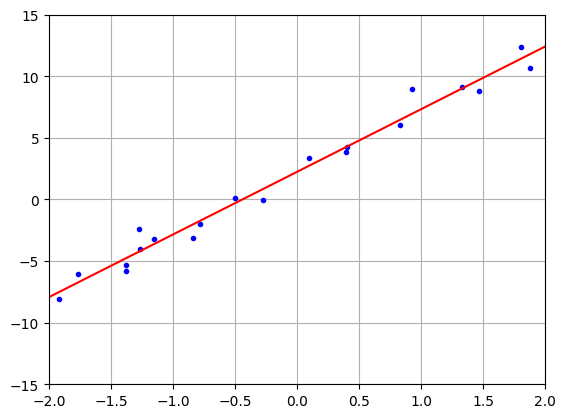

In [4]:
# -----------------------------
# 1. Generate synthetic data
# -----------------------------
np.random.seed(42)
x_data = np.sort(-2. + 4. * np.random.rand(20))
y_data = 5. * x_data + 2.5 + np.random.randn(20)

X = torch.tensor(x_data[:, np.newaxis], dtype=torch.float32)
Y = torch.tensor(y_data[:, np.newaxis], dtype=torch.float32)

dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=20, shuffle=True)

# -----------------------------
# 2. Define Model
# -----------------------------
class MyFirstANN(pl.LightningModule):
    def __init__(self, lr=0.1):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=True)
        self.lr = lr

    def forward(self, x):
        return self.linear(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

# -----------------------------
# 3. Train the model
# -----------------------------
model = MyFirstANN(lr=0.1)
trainer = Trainer(max_epochs=50, enable_checkpointing=False, logger=False)
trainer.fit(model, loader)

# -----------------------------
# 4. Visualization
# -----------------------------
plt.plot(x_data, y_data, 'b.')
x = torch.tensor(np.linspace(-2.0, 2.0, 100).reshape(-1,1), dtype=torch.float32)
y = model(x).detach().numpy()
plt.plot(x, y, 'r')
plt.ylim([-15, 15])
plt.xlim([-2, 2])
plt.grid('on')
plt.show()


## Non-Linear Example

We will design a 2-Hidden layers Neural Network to predict the following data

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | h         | Sequential | 61     | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
61        Trainable params
0         Non-trainable params
61        Total params
0.000     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1000` reached.


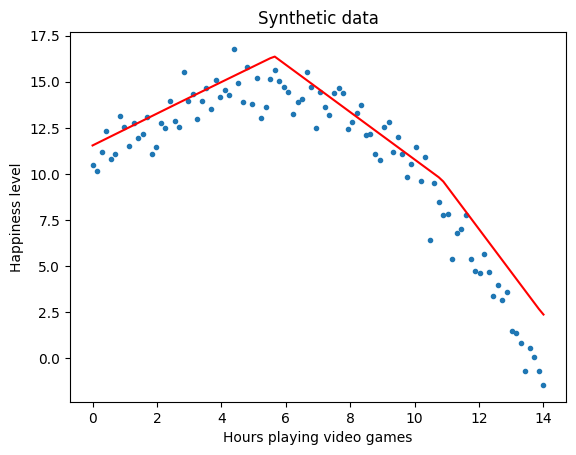

In [5]:
# Generate synthetic data
np.random.seed(42)
hours = torch.linspace(0, 14, 100).view(-1, 1)
happiness = 10 + 2 * hours + 0.2*np.random.normal(0, 5, 100).astype(np.float32).reshape(-1,1) - 0.2 * hours**2

x = hours
y = happiness

# Prepare dataset and dataloader
dataset = TensorDataset(x, y)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define Multilayer perceptron
class MyMLP(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.h = nn.Sequential(
                    nn.Linear(1, 6),
                    nn.ReLU(),
                    nn.Linear(6, 6),
                    nn.ReLU(),
                    nn.Linear(6, 1)
                )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.h(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.001)

# Instantiate model
model = MyMLP()

# Trainer
trainer = pl.Trainer(max_epochs=1000, enable_progress_bar=False, enable_checkpointing=False, logger=False)
trainer.fit(model, train_loader)

# Plot results
plt.plot(x, y, '.')
with torch.no_grad():
    out = model(x)
plt.plot(x, out.numpy(), 'r')
plt.xlabel('Hours playing video games')
plt.ylabel('Happiness level')
plt.title('Synthetic data')
plt.show()

# MNIST Image Classification
### 1.  Loading the MNIST dataset
The data is contained in the ```training_data.data``` and the labels
in ```training_data.targets```.

You can also access the data using indexing ```training_data[index]```

The ```Dataset``` retrieves our dataset’s features and labels one sample at a time. While training a model, 
we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting

```DataLoader``` is an iterable that abstracts this complexity for us in an easy API.

```train_features, train_labels = next(iter(train_dataloader))```

[Additional Reading](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [11]:
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

training_data = datasets.MNIST(
    root='~/Downloads/',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.MNIST(
    root='~/Downloads/',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

batchsize = 64
train_loader = DataLoader(training_data, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(test_data, batch_size=8, shuffle=True)

### 2.  Create a multiclass logistic regression (softmax) model and train

In [12]:
# -------------------------
# Lightning model
# -------------------------
class MNISTClassifier(pl.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 10, bias=True),
        )
        self.criterion = nn.CrossEntropyLoss()

        self.lr = lr

    def forward(self, x):
        x = x.view(x.size(0), -1)   # flatten input
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        #self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

# -------------------------
# Training
# -------------------------
model = MNISTClassifier(lr=0.001)

trainer = pl.Trainer(
    max_epochs=10,
    log_every_n_steps=50,
    accelerator="auto"   # will use GPU/MPS/CPU automatically
)
trainer.fit(model, train_loader, val_loader)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/oarif/Documents/workspace/COE49413/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 7.9 K  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Training: |                                                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### 3. Test on a batch of test images and display images with the predicted label

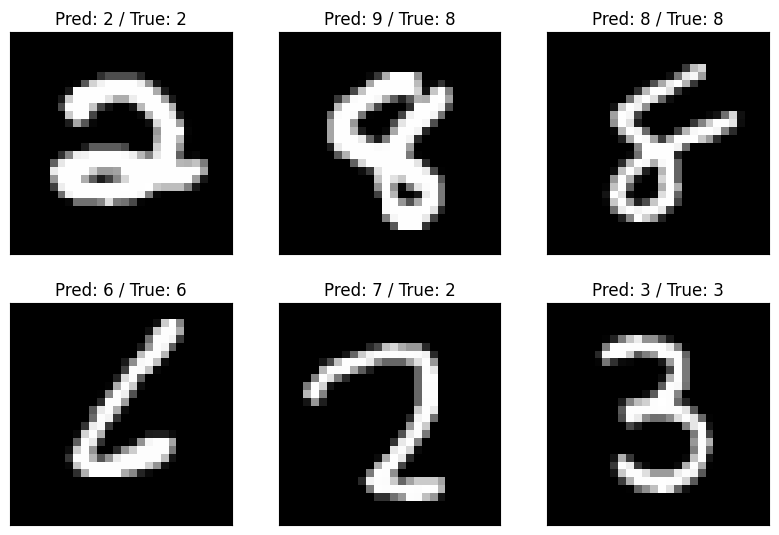

In [14]:
import matplotlib.pyplot as plt
import torch

# put model in eval mode
model.eval()

# get one batch from test (val) dataloader
inputs_im, labels = next(iter(val_loader))

with torch.no_grad():
    out = model(inputs_im)  # forward pass
    preds = torch.argmax(out, dim=1)

# plot first 6 images with predictions
fig = plt.figure(figsize=(8, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    im = inputs_im[i].squeeze(0).numpy()
    plt.imshow(im, cmap="gray", interpolation="none")
    plt.title(f"Pred: {preds[i].item()} / True: {labels[i].item()}")
    plt.xticks([])
    plt.yticks([])

plt.show()